# FRUIT INSPECTION
## First Task: Fruit segmentation and defect detection

Students should:

> **Outline the fruit by generating a binary mask**

**HINT**: first threshold the whole image in order to remove the background, but
keeping intact the fruit borders; then
fill the holes inside the fruit blob using a flood-fill approach. The image pair has little parallax, so a mask might be
computed on one image and then applied on the other one.

> **Search for the defects on each fruit**

**HINT**: the defects have strong edges, so edge extraction algorithm should help. Also, they usually exhibit a far
darker color with respect to the neighboring areas of the fruit.

## Import and Image Management
In this section we import the necessaries libraries and retrive the images from google drive. Then we unzip the folder and start working

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import os

In [ ]:
! gdown --id 12vNN-PcvycfyN8TMREQStGl_9Rx_Ivm5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12vNN-PcvycfyN8TMREQStGl_9Rx_Ivm5
To: /content/images.zip
100% 1.01M/1.01M [00:00<00:00, 113MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

Taken the folder, images are loaded in alphabetical order (sorted) and it is checked in the title if it is present:
* "C1" for color images, placed in color_images
* "C0" for black and white images, placed in gray_images

An image will have the same index in the gray or colored list (e.g. the corresponding grey image of color_images[0] will be in grey_images[0])

Then we print them out so we can show them and start working on them

In [ ]:
# assign directory
directory = '/content/images/task1/'
 
grey_images = []
color_images = []
# iterate over files in that directory, sorted
for filename in sorted(os.listdir(directory)):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    # if C1 then is colored image
    if "/content/images/task1/C1" in f:
      img = cv.imread(f)
      color_images.append(img)
    # if C0 then is gray image
    elif "/content/images/task1/C0" in f:
      img = cv.imread(f, cv.IMREAD_GRAYSCALE)
      grey_images.append(img)

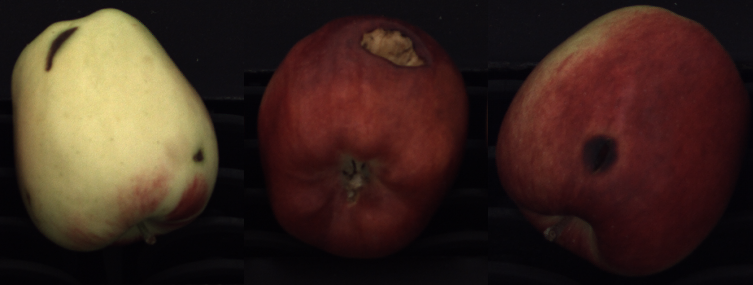

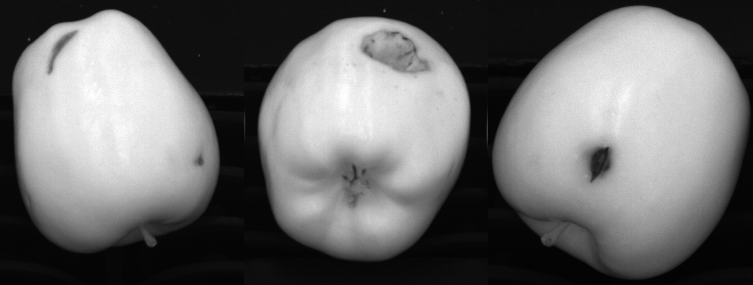

In [ ]:
# function to resize the images to show them with horizontal concatenation
def hconcat_resize(images, interpolation = cv.INTER_CUBIC):
  # take minimum hights
  h_min = min(img.shape[0] for img in images)
    
  # image resizing 
  images_resized = [cv.resize(img, (int(img.shape[1] * h_min / img.shape[0]),
                      h_min), interpolation = interpolation)
                    for img in images]
    
  # return final image
  return cv.hconcat(images_resized)
  
# show colored and grey images concatenated
# it should be cv.imshow, but in colab is disabled because it causes crashes.
cv2_imshow(hconcat_resize(color_images))
cv2_imshow(hconcat_resize(grey_images))

We then show the histogram of the grey images

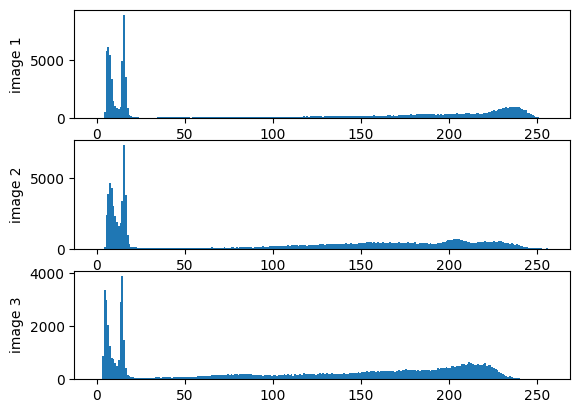

In [ ]:
'''
cv.calcHist function:

images: It is an image source of type uint8 or float32.
channels: It represents the index of the channel. It is given in a square bracket. For the grayscale image, its value is [0].
mask: It represents a mask image. To find the histogram of the full image, it is given as "None".
histSize: It represents the number of bins provided as a list.
ranges: It represents the range of intensity values.
'''
for i in range(len(grey_images)):
  plt.subplot(int("31" + str(i+1)))
  hist = cv.calcHist(grey_images[i], [0], None, [256], [0,256])
  plt.hist(grey_images[i].ravel(),256,[0,256])
  plt.ylabel('image ' + str(i+1))
plt.show()

# 1. Outline the fruit by generating a binary mask

We need to threshold the whole image in order to remove the background, but keeping intact the fruit borders.

We have chosen to apply the **Otsu** thresholding

Then we show the original image, the histogram with the threshold and the image after applying the threshold

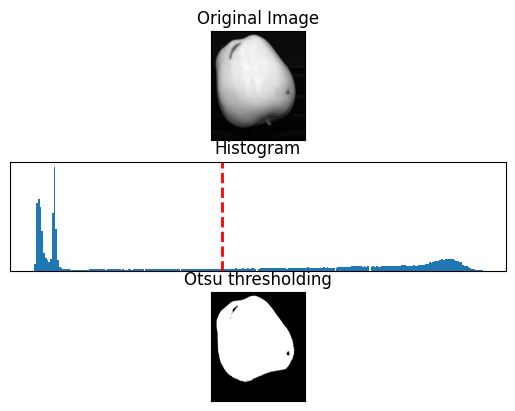

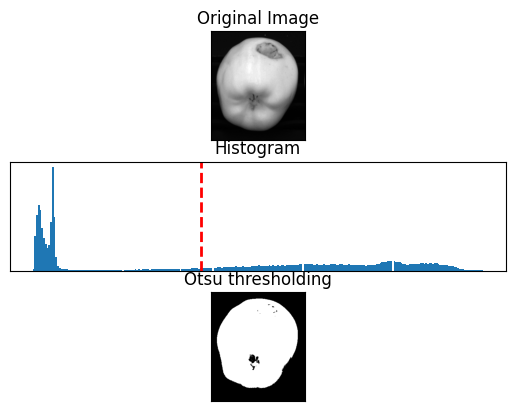

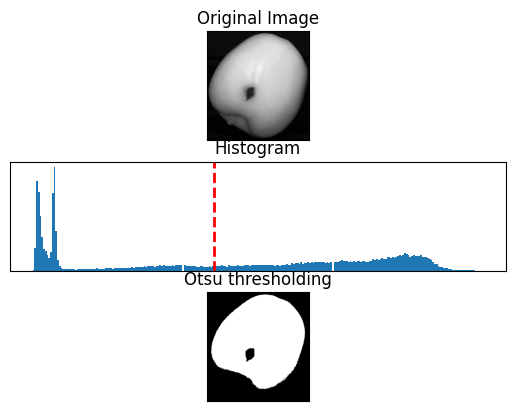

In [ ]:
ret_list = []
im_th_list = []

for i in range(len(grey_images)):
  ret, im_th = cv.threshold(grey_images[i], 0, 255, cv.THRESH_OTSU)
  ret_list.append(ret)
  im_th_list.append(im_th)

  # subplot of the original image
  # cmap is needed because we need the grayscale
  plt.subplot(3,1,1), plt.imshow(grey_images[i],cmap = 'gray')
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])

  # subplot of the histogram
  plt.subplot(3,1,2), plt.hist(grey_images[i].ravel(), 256)
  plt.axvline(x=ret_list[i], color='r', linestyle='dashed', linewidth=2)
  plt.title('Histogram'), plt.xticks([]), plt.yticks([])

  # subplot of the image after the Otsu thresholding application
  plt.subplot(3,1,3), plt.imshow(im_th_list[i],cmap = 'gray')
  plt.title('Otsu thresholding'), plt.xticks([]), plt.yticks([])
  plt.show()

Showing the resulting images

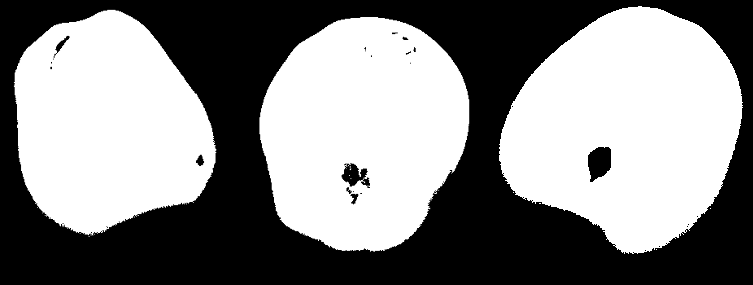

In [ ]:
cv2_imshow(hconcat_resize(im_th_list))

We'll fill the holes inside the fruit blob. Starting from the first pixel in position (0,0) we'll fill everything that is set as 0 from the Otsu thresholding flood-fill approach.
We choose to color everything with grey and then recolor the background with black. We then realize the mask as a binary image

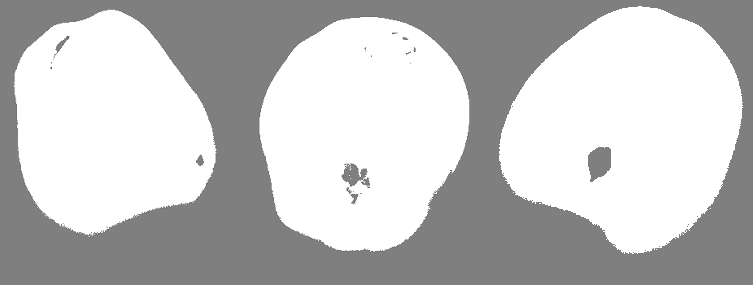

In [ ]:
# color of the black pixels in order to differentiate the imperfections from the background
for i in range(len(im_th_list)):
  im_th_list[i][im_th_list[i] == 0] = 127

# show threshold image
cv2_imshow(hconcat_resize(im_th_list))

In [ ]:
# Copy the thresholded image.
im_floodfill = []

for i in range(len(im_th_list)):
  im_floodfill.append(im_th_list[i].copy())

  '''
  A mask is a binary image that defines the region of interest within an image.
  It is typically used to filter out unwanted regions or to focus the algorithm 
  on specific regions of interest. 
  In order to achieve flood-filling in computer vision, a mask is often used to 
  limit the area where the flood-fill algorithm is applied.

  The size of the mask used for flood-filling should be two pixels larger in each 
  dimension than the image being processed.

  This is important because the mask needs to completely cover the image with a 
  border of one pixel around the edges. The border helps to prevent the flood-fill 
  algorithm from overflowing outside the image boundaries and filling unintended 
  areas. By making the mask two pixels larger in each dimension, the mask will 
  cover the entire image with a one-pixel border around the edges.

  '''
  # we get the first two elements because the third is the channels, 
  # and we don't need them now.
  h, w = im_th_list[i].shape[:2]

  # Mask used to flood filling.
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0), that is the seed point.
  # The new value to be assigned to the filled pixels
  cv.floodFill(im_floodfill[i], mask, (0,0), 0);

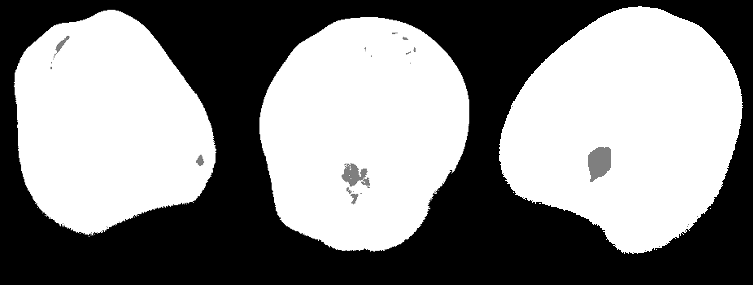

In [ ]:
cv2_imshow(hconcat_resize(im_floodfill))

The result are good, but in the second image we can see that the real defect is barely visible while the bottom of the apple is well highlighted. We'll try with the edge detection.

# 2. Search for the defects on each fruit

In order to search for the defects, we could try to apply edge detection. 

We need to use the original images because edge detection algorithms work by computing the intensity gradients of an image, which are sensitive to variations in intensity within the image.

If the image is pre-segmented, the gradient values may not accurately reflect the true boundaries between objects or regions of interest, since these boundaries may not align with the segmentation boundaries.

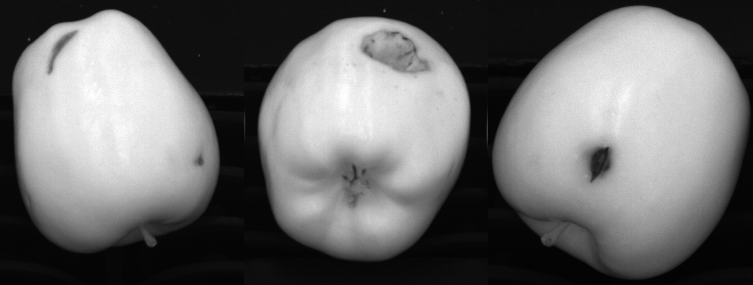

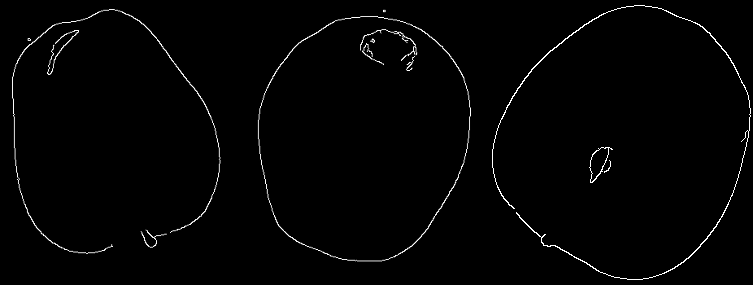

In [ ]:
cv2_imshow(hconcat_resize(grey_images))

edges = []

for i in range(len(grey_images)):
  # Canny Edge Detection
  edges.append(cv.Canny(image=grey_images[i], threshold1=70, threshold2=230))

cv2_imshow(hconcat_resize(edges))

With edge detection, if we use a threshold that is too low, we obtain a False positive in the second apple, due to the bottom of the apple core (as we obtain with the flood fill approach). If we try to increase the Th (higher threshold) to a higher value, the problem is solved.

We then apply erosion using the floodfilled masks so the only the edges that remains will be those of the imperfections.

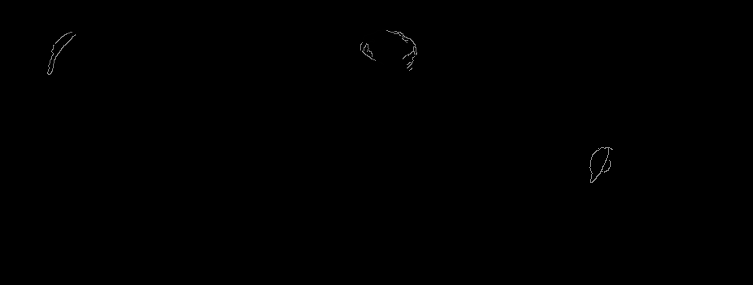

In [ ]:
# An elliptical kernel is often used for erosion because it can better preserve the shape of objects in the image than a circular or square kernel.
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
filtered_edges = []
for i in range(len(grey_images)):
  eroded_mask = cv.erode(im_floodfill[i], kernel, iterations = 10)
  filtered_edges.append(edges[i] * eroded_mask)
cv2_imshow(hconcat_resize(filtered_edges))

We notice that this output is better than the previous one, because the big imperfection on the second image is detected.

As we can see, there are not false positives, but we also removed the small imperfection on the first apple.

To show the edges of the imperfections we drow them on the colored images.

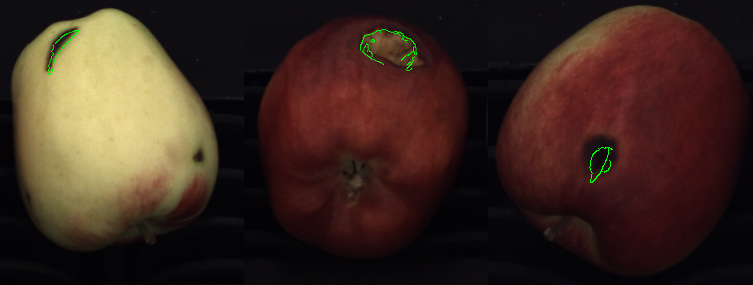

In [ ]:
detected_imperfections = []
final_images = color_images.copy()

for i, edge in enumerate(filtered_edges):
  m, n, _ = final_images[i].shape
  for j in range(m):
    for k in range(n):
      if edge[j,k] != 0:
        final_images[i][j,k,0] = 0
        final_images[i][j,k,1] = 255
        final_images[i][j,k,2] = 0
  detected_imperfections.append(final_images[i])

cv2_imshow(hconcat_resize(detected_imperfections))

## Made by 
  - Luca Reggiani
  - Simone Vizuso